In [2]:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
import numpy as np

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.layers import Dense

import matplotlib.pyplot as plt

## Helper Functions

In [4]:
MODEL_NAMES = ["Model 1 - CNN",
               "Model 2 - CNN",
               "Model 3 - CNN",
               "Model 4 - CNN",
               "Model 5 - CNN-LSTM",
               "Model 6 - CNN-LSTM",
               "Model 7 - CNN-LSTM"]

In [5]:
def load_models():
    models = {}
    for i in range(1,8):
        models[i] = load_model(f"../models/model{i}.h5")
    return models

In [6]:
def get_history(X_train, y_train, X_test, y_test):
    models = load_models()
    hist = {}
    stop_early = EarlyStopping(monitor='val_loss', patience=10)

    for i in models:
        models[i].pop()
        models[i].add(Dense(units=y_train.shape[1], activation="softmax", name="output_layer"))
        models[i].compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])


    for i in range(1,8):
        hist[i] = models[i].fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=stop_early)
    return hist, models

In [7]:
def get_acc(models, X_test, y_test):
    accs = []
    for i in models:
        accs.append(models[i].evaluate(X_test, y_test))
    return accs

In [39]:
def get_classification_report(X_test, y_test, models, encoder):
    pred_tests, y_preds, report = {}, {}, {}
    for i in range(1,8):
        pred_tests[i] = models[i].predict(X_test)
    for j in range(1,8):
        y_preds[j] = encoder.inverse_transform(pred_tests[j])

    for ii in range(1,8):
        print(classification_report(y_test, y_preds[ii]))

In [9]:
def plot_history(data_name, hist, accs):
    train_acc, train_loss, test_acc, test_loss, epochs = {}, {}, {}, {}, {}
    for i in range(1,8):
        train_acc[i] = hist[i].history['accuracy']
        train_loss[i] = hist[i].history['loss']
        test_acc[i] = hist[i].history['val_accuracy']
        test_loss[i] = hist[i].history['val_loss']
        epochs[i] = len(hist[i].history['loss'])
    
    fig = plt.figure(figsize=(30,45))
    fig.suptitle(data_name)
    subfigs = fig.subfigures(7,1)
    for row, subfig in enumerate(subfigs):
        subfig.suptitle(MODEL_NAMES[row] + f" - Accuracy: {round(accs[row][1]*100, 2)}")

        ax = subfig.subplots(1,2)
        ax[0].plot(train_loss[row+1], label='Training Loss')
        ax[0].plot(test_loss[row+1], label='Validation Loss')
        ax[0].set_title('Training & Validation Loss')
        ax[0].legend()
        ax[0].set_xlabel("Epochs")

        ax[1].plot(train_acc[row+1], label='Training Accuracy')
        ax[1].plot(test_acc[row+1], label='Validation Accuracy')
        ax[1].set_title('Training & Validation Accuracy')
        ax[1].legend()
        ax[1].set_xlabel("Epochs")
    
    plt.savefig(f"../figs/{data_name}.png")


### 1. RAVDESS

In [43]:
ravdess_x = np.load("ravdess_feats.npy")
ravdess_y = np.load("ravdess_labels.npy")

In [44]:
ravdess_x.shape, ravdess_y.shape

((4320, 162), (4320,))

In [45]:
enc = OneHotEncoder()
ravdess_y = enc.fit_transform(ravdess_y.reshape(-1,1)).toarray()

In [46]:
RX_train, RX_test, Ry_train, Ry_test = train_test_split(ravdess_x, ravdess_y, test_size=0.3, random_state=42, shuffle=True)
scaler = StandardScaler()
RX_train = scaler.fit_transform(RX_train)
RX_test = scaler.transform(RX_test)
np.expand_dims(RX_train, axis=2)
np.expand_dims(RX_test, axis=2)
RX_train.shape, RX_test.shape, Ry_train.shape, Ry_test.shape

((3024, 162), (1296, 162), (3024, 8), (1296, 8))

In [47]:
ravdess_hist, ravdess_models = get_history(RX_train, Ry_train, RX_test, Ry_test)

Epoch 1/100
95/95 [==============================] - 3s 13ms/step - loss: 2.0256 - accuracy: 0.2090 - val_loss: 1.9771 - val_accuracy: 0.1682
Epoch 2/100
95/95 [==============================] - 1s 9ms/step - loss: 1.8994 - accuracy: 0.2440 - val_loss: 2.0159 - val_accuracy: 0.1644
Epoch 3/100
95/95 [==============================] - 1s 9ms/step - loss: 1.8552 - accuracy: 0.2682 - val_loss: 2.0568 - val_accuracy: 0.1721
Epoch 4/100
95/95 [==============================] - 1s 10ms/step - loss: 1.8097 - accuracy: 0.2794 - val_loss: 2.0974 - val_accuracy: 0.1605
Epoch 5/100
95/95 [==============================] - 1s 9ms/step - loss: 1.7652 - accuracy: 0.3132 - val_loss: 2.0015 - val_accuracy: 0.2446
Epoch 6/100
95/95 [==============================] - 1s 9ms/step - loss: 1.7256 - accuracy: 0.3214 - val_loss: 1.9849 - val_accuracy: 0.1937
Epoch 7/100
95/95 [==============================] - 1s 9ms/step - loss: 1.6939 - accuracy: 0.3399 - val_loss: 1.7801 - val_accuracy: 0.2894
Epoch 8/100

In [48]:
ravdess_accs = get_acc(ravdess_models, RX_test, Ry_test)

41/41 [==============================] - 0s 3ms/step - loss: 1.2079 - accuracy: 0.5795


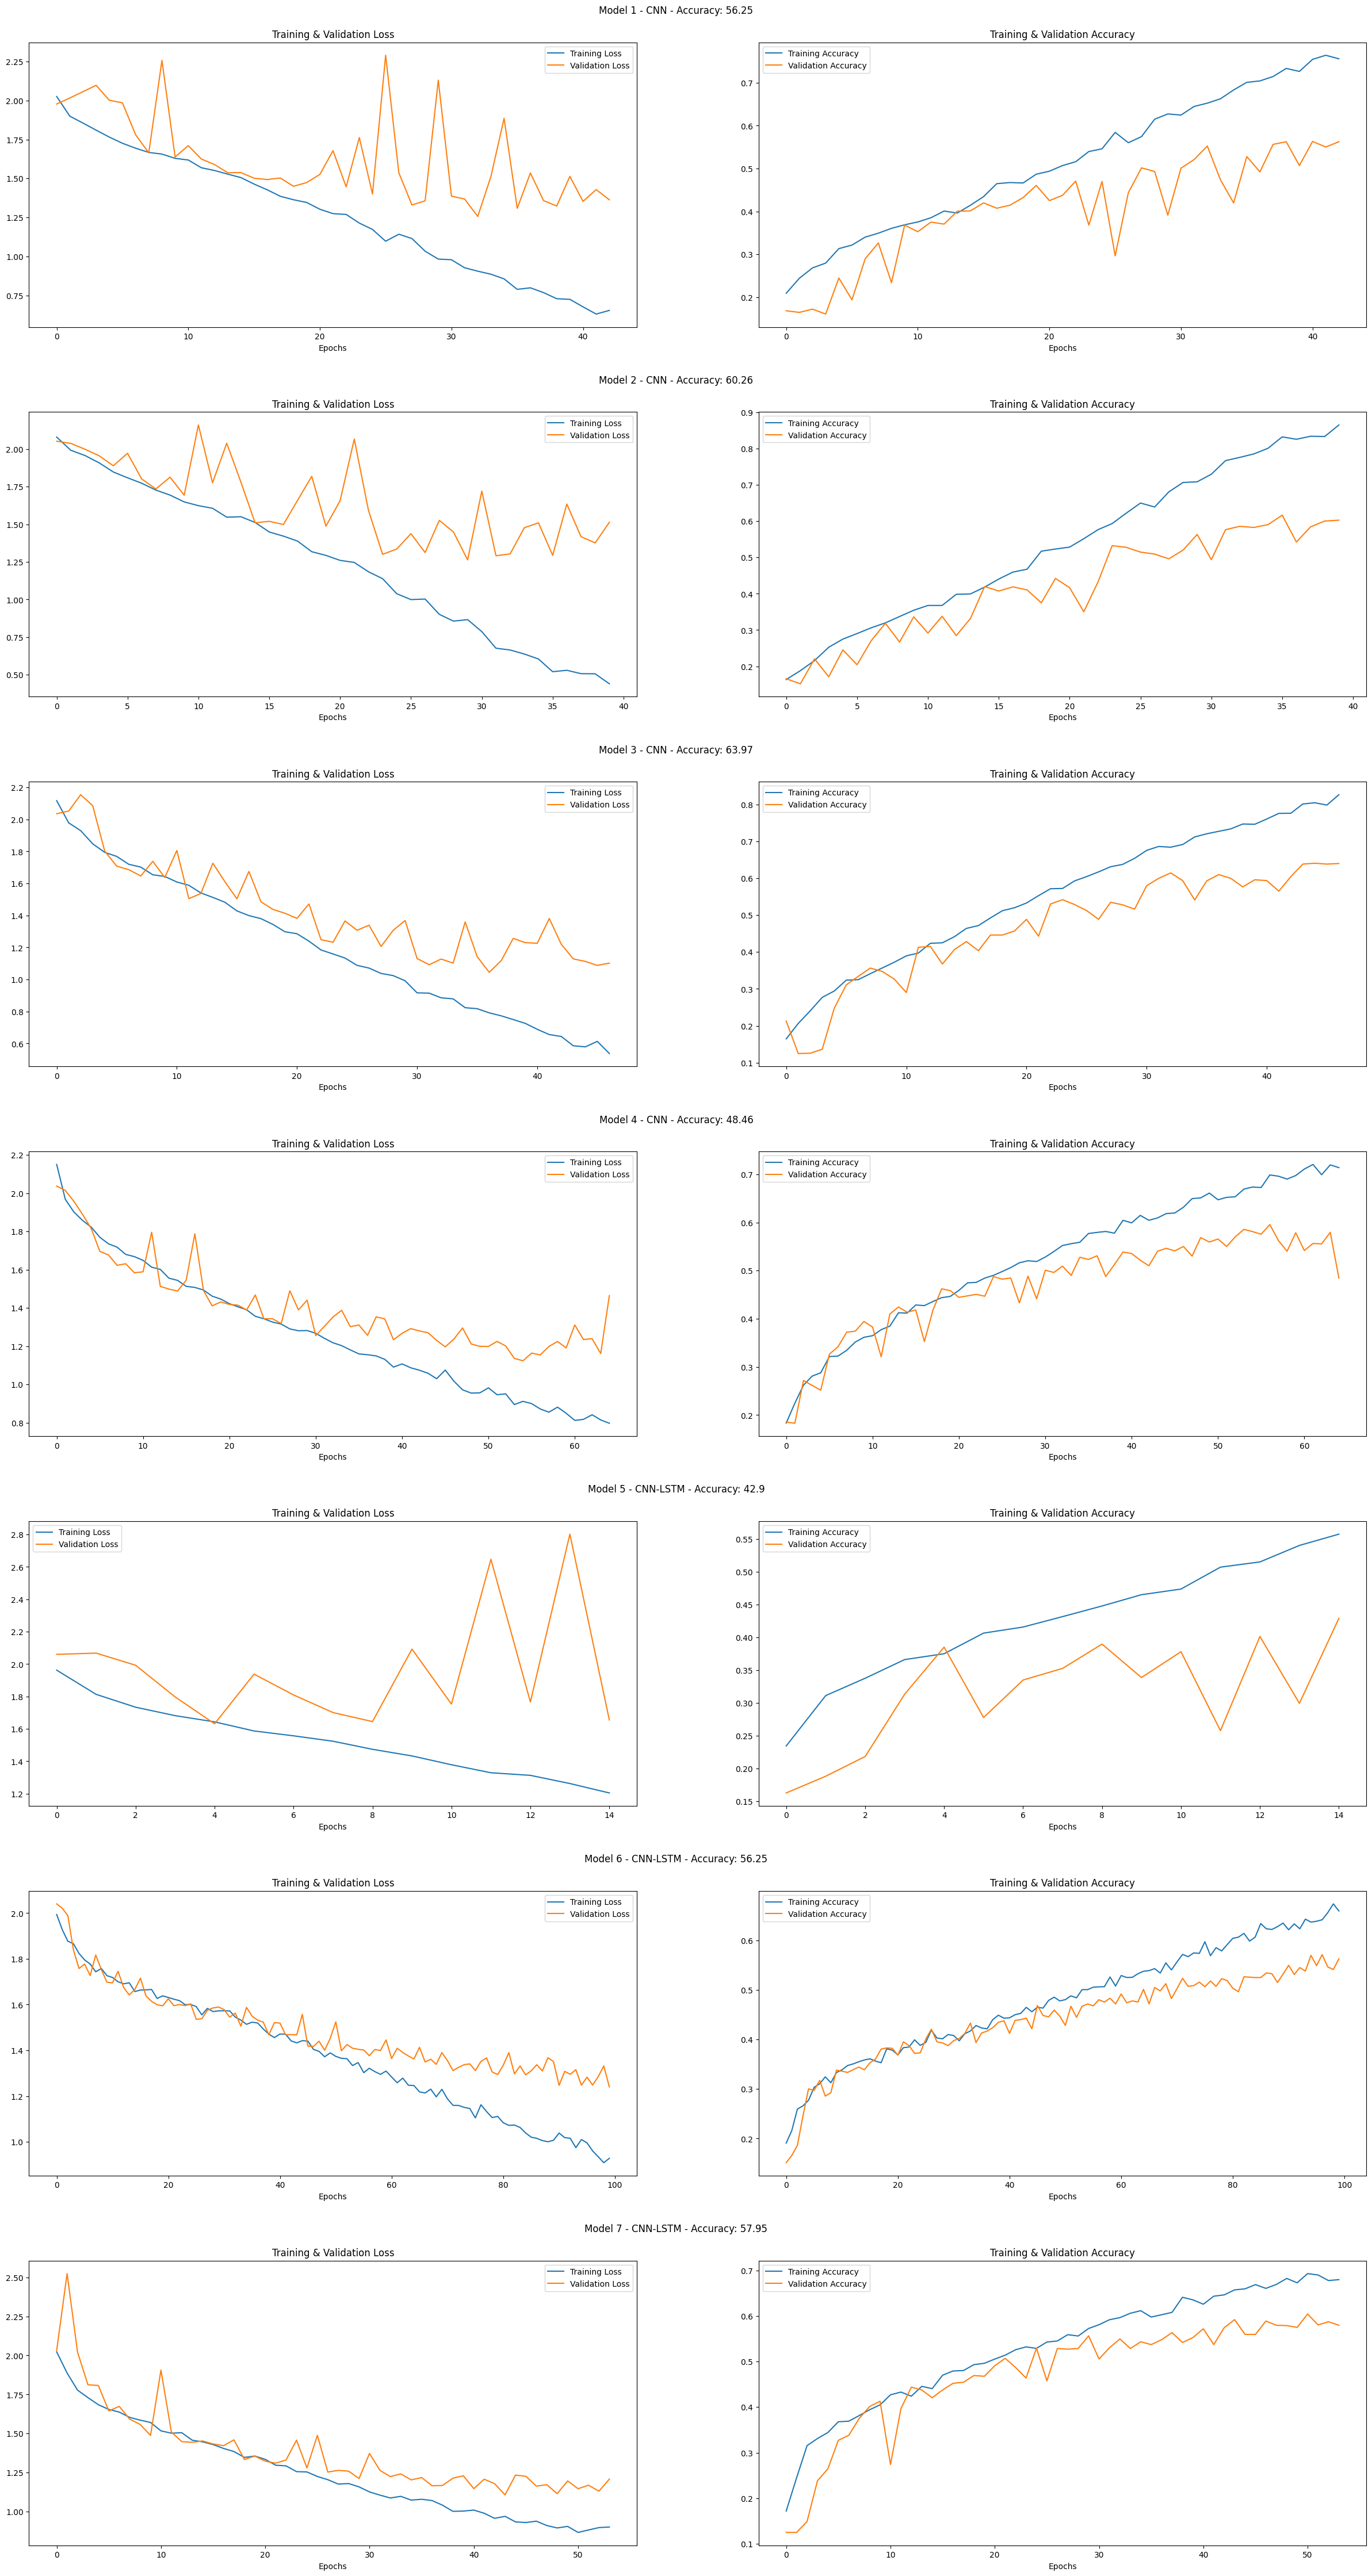

In [49]:
plot_history("Ravdess", ravdess_hist, ravdess_accs)

In [50]:
Ry_test = enc.inverse_transform(Ry_test)
ravdess_report = get_classification_report(RX_test, Ry_test, ravdess_models, enc)

41/41 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

       angry       0.50      0.82      0.62       162
        calm       0.64      0.68      0.66       166
     disgust       0.72      0.35      0.47       183
        fear       0.53      0.70      0.60       172
       happy       0.49      0.48      0.48       183
     neutral       0.33      0.37      0.35        91
         sad       0.62      0.37      0.47       163
    surprise       0.72      0.66      0.69       176

    accuracy                           0.56      1296
   macro avg       0.57      0.55      0.54      1296
weighted avg       0.59      0.56      0.55      1296

              precision    recall  f1-score   support

       angry       0.69      0.78      0.73       162
        calm       0.73      0.69      0.71       166
     disgust       0.64      0.56      0.60       183
        fear       0.78      0.35      0.49       172
       happy       0.42  

### 2. CREMA

In [51]:
crema_x = np.load("crema_feats.npy")
crema_y = np.load("crema_labels.npy")
crema_x.shape, crema_y.shape

((22326, 162), (22326,))

In [52]:
crema_y = enc.fit_transform(crema_y.reshape(-1,1)).toarray()

In [53]:
CX_train, CX_test, Cy_train, Cy_test = train_test_split(crema_x, crema_y, random_state=42, shuffle=True)
scaler = StandardScaler()
CX_train = scaler.fit_transform(CX_train)
CX_test = scaler.transform(CX_test)
np.expand_dims(CX_train, axis=2)
np.expand_dims(CX_test, axis=2)
CX_train.shape, CX_test.shape, Cy_train.shape, Cy_test.shape

((16744, 162), (5582, 162), (16744, 6), (5582, 6))

In [54]:
crema_hist, crema_models = get_history(CX_train, Cy_train, CX_test, Cy_test)
crema_accs = get_acc(crema_models, CX_test, Cy_test)

Epoch 1/100
524/524 [==============================] - 7s 10ms/step - loss: 1.6260 - accuracy: 0.2996 - val_loss: 1.5223 - val_accuracy: 0.3504
Epoch 2/100
524/524 [==============================] - 5s 9ms/step - loss: 1.5498 - accuracy: 0.3401 - val_loss: 1.5796 - val_accuracy: 0.3379
Epoch 3/100
524/524 [==============================] - 4s 9ms/step - loss: 1.5322 - accuracy: 0.3499 - val_loss: 1.5340 - val_accuracy: 0.3669
Epoch 4/100
524/524 [==============================] - 4s 9ms/step - loss: 1.5222 - accuracy: 0.3554 - val_loss: 1.5718 - val_accuracy: 0.3334
Epoch 5/100
524/524 [==============================] - 5s 9ms/step - loss: 1.5078 - accuracy: 0.3631 - val_loss: 1.4487 - val_accuracy: 0.4036
Epoch 6/100
524/524 [==============================] - 5s 9ms/step - loss: 1.4956 - accuracy: 0.3700 - val_loss: 1.4999 - val_accuracy: 0.3805
Epoch 7/100
524/524 [==============================] - 5s 9ms/step - loss: 1.4852 - accuracy: 0.3738 - val_loss: 1.4848 - val_accuracy: 0.367

2023-06-09 21:31:32.051444: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:288] gpu_async_0 cuMemAllocAsync failed to allocate 2181048320 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 2097152/4100456448
2023-06-09 21:31:32.051486: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:293] Stats: Limit:                      2218786816
InUse:                       214828316
MaxInUse:                   2234271168
NumAllocs:                    80405960
MaxAllocSize:               2192146432
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2023-06-09 21:31:32.051568: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:56] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2023-06-09 21:31:32.051573: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.

524/524 [==============================] - 11s 13ms/step - loss: 1.5705 - accuracy: 0.3328 - val_loss: 1.4867 - val_accuracy: 0.3850
Epoch 2/100
 13/524 [..............................] - ETA: 4s - loss: 1.4809 - accuracy: 0.3558

2023-06-09 21:31:33.391075: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:288] gpu_async_0 cuMemAllocAsync failed to allocate 3804243968 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 2097152/4100456448
2023-06-09 21:31:33.391134: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:293] Stats: Limit:                      2218786816
InUse:                       222574576
MaxInUse:                   2234271168
NumAllocs:                    80434601
MaxAllocSize:               2192146432
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2023-06-09 21:31:33.391230: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:56] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2023-06-09 21:31:33.391235: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.

524/524 [==============================] - 5s 10ms/step - loss: 1.5040 - accuracy: 0.3690 - val_loss: 1.4680 - val_accuracy: 0.3852
Epoch 3/100
524/524 [==============================] - 5s 10ms/step - loss: 1.4766 - accuracy: 0.3827 - val_loss: 1.4793 - val_accuracy: 0.3755
Epoch 4/100
524/524 [==============================] - 5s 10ms/step - loss: 1.4560 - accuracy: 0.3987 - val_loss: 1.4336 - val_accuracy: 0.4183
Epoch 5/100
524/524 [==============================] - 6s 11ms/step - loss: 1.4359 - accuracy: 0.4049 - val_loss: 1.4213 - val_accuracy: 0.4171
Epoch 6/100
524/524 [==============================] - 5s 10ms/step - loss: 1.4225 - accuracy: 0.4170 - val_loss: 1.4011 - val_accuracy: 0.4203
Epoch 7/100
524/524 [==============================] - 5s 10ms/step - loss: 1.4057 - accuracy: 0.4230 - val_loss: 1.3595 - val_accuracy: 0.4489
Epoch 8/100
524/524 [==============================] - 6s 11ms/step - loss: 1.3955 - accuracy: 0.4276 - val_loss: 1.3753 - val_accuracy: 0.4368
Epoc

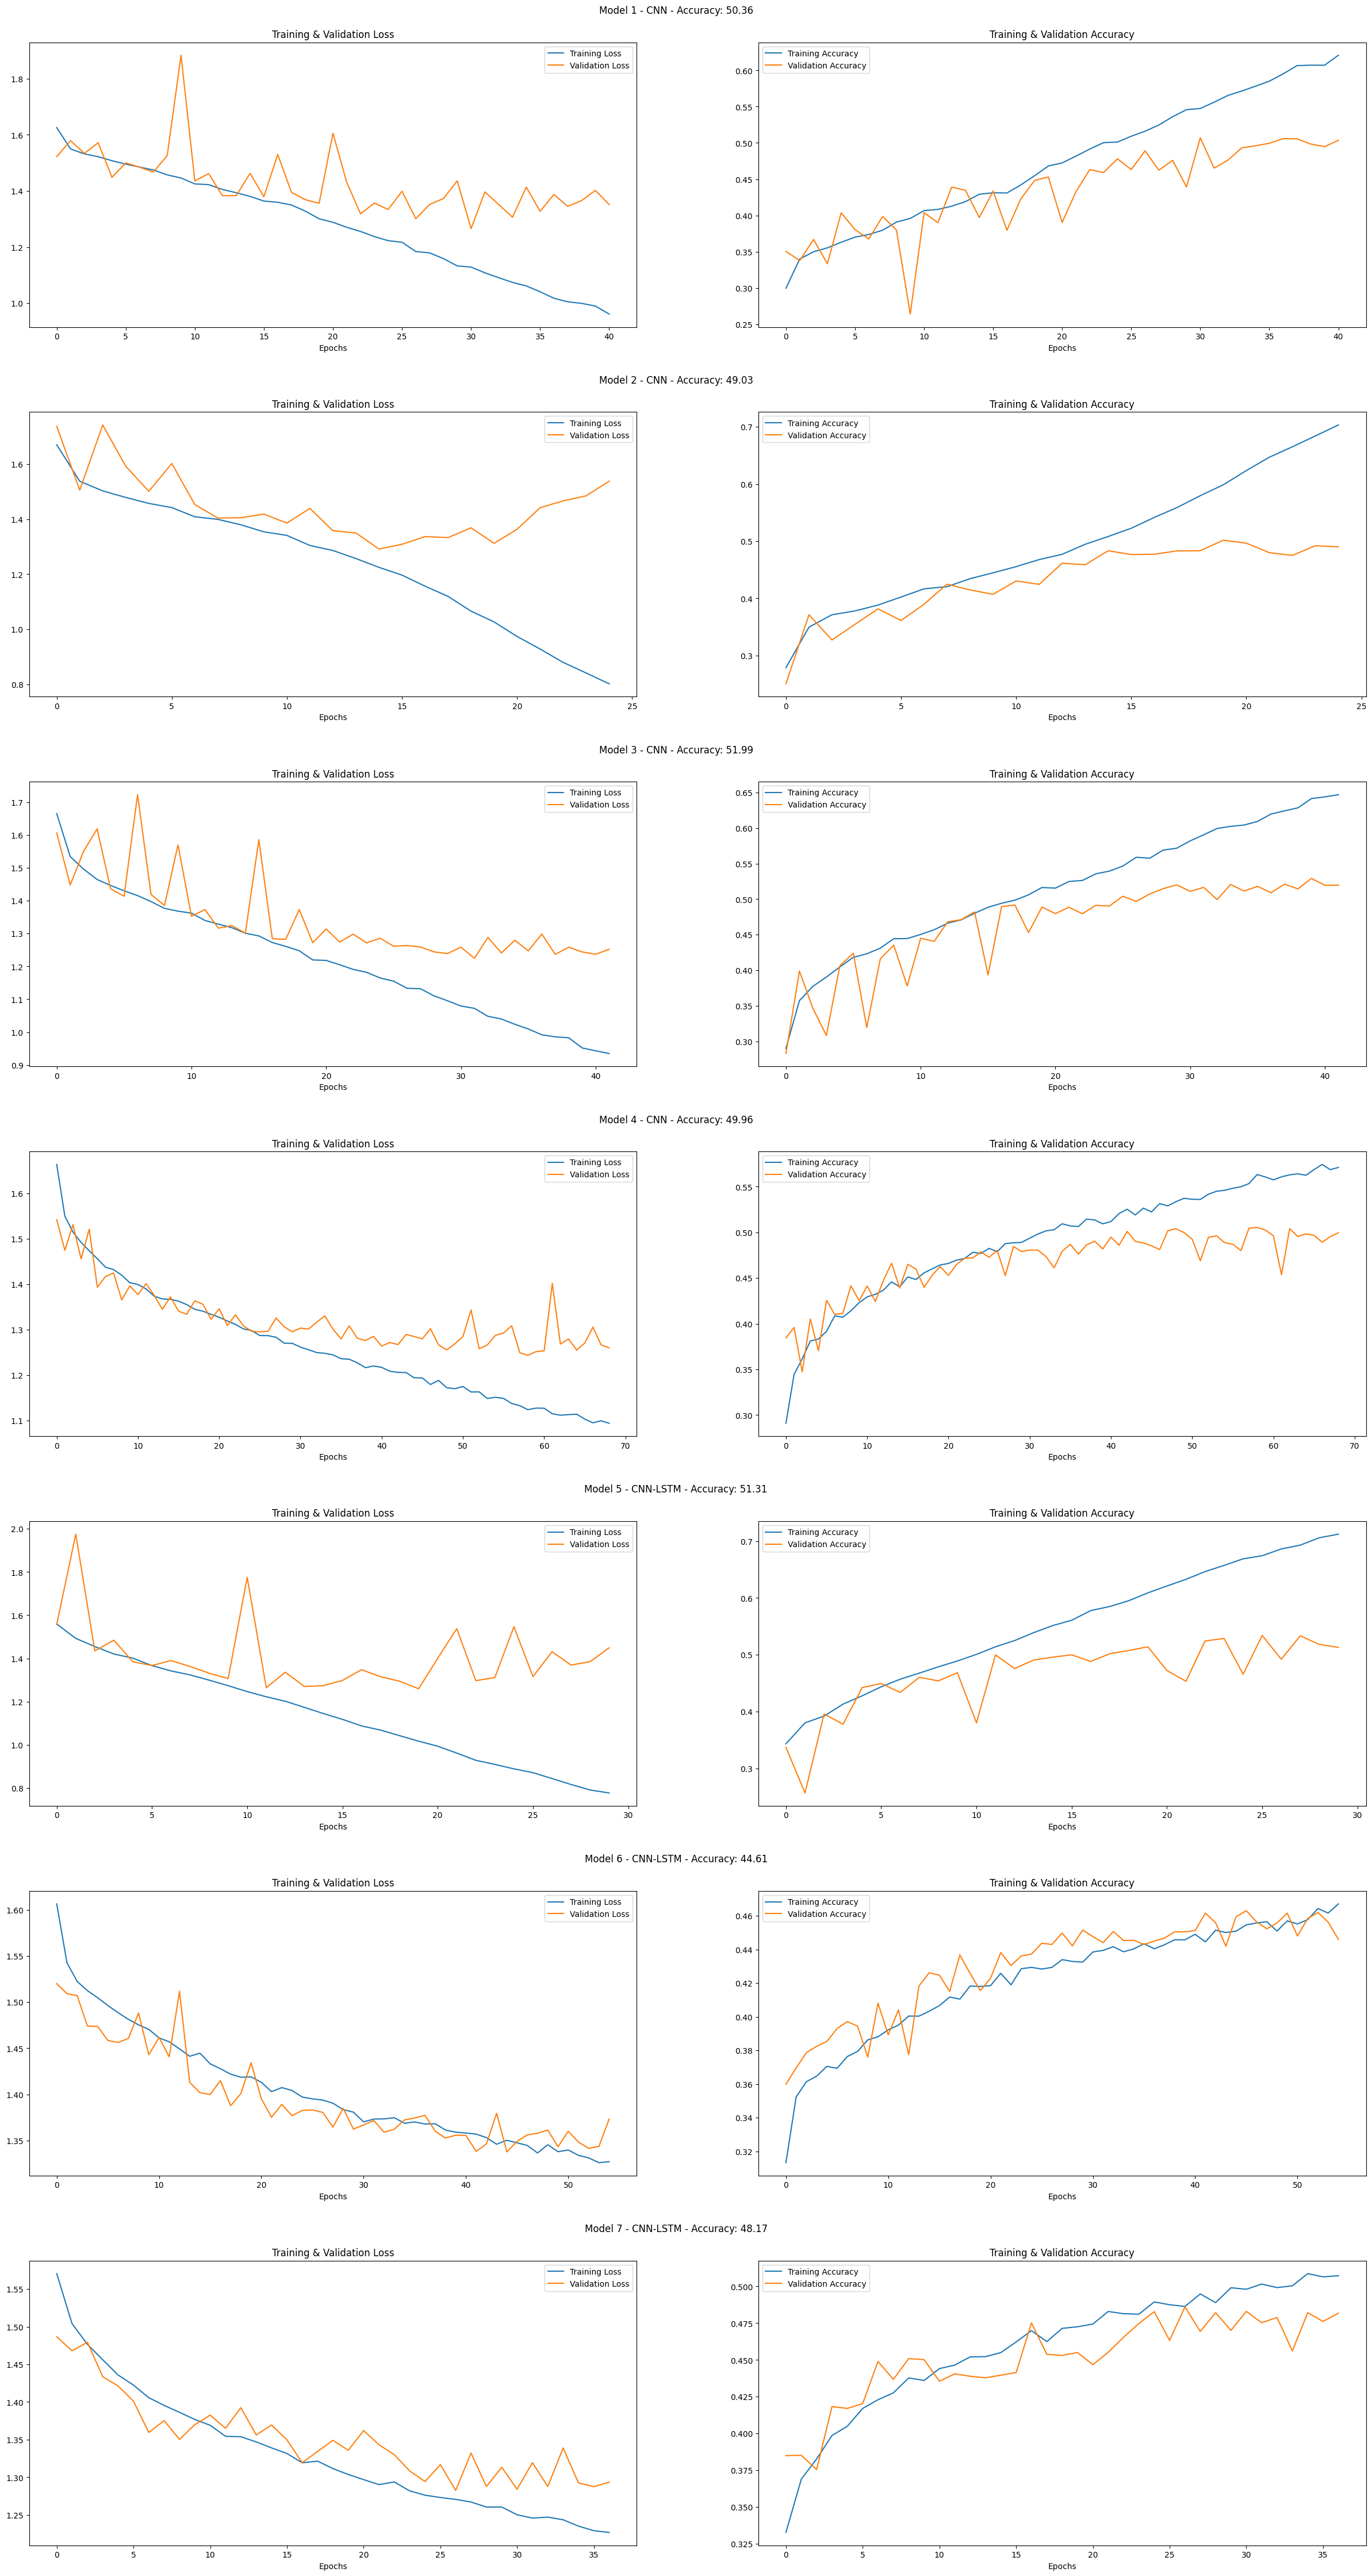

In [55]:
plot_history("Crema", crema_hist, crema_accs)

In [56]:
Cy_test = enc.inverse_transform(Cy_test)
get_classification_report(CX_test, Cy_test, crema_models, enc)

175/175 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

       angry       0.77      0.67      0.71      1003
     disgust       0.41      0.25      0.31       939
        fear       0.58      0.35      0.44       903
       happy       0.55      0.40      0.47       954
     neutral       0.40      0.56      0.47       843
         sad       0.43      0.78      0.55       940

    accuracy                           0.50      5582
   macro avg       0.52      0.50      0.49      5582
weighted avg       0.53      0.50      0.49      5582

              precision    recall  f1-score   support

       angry       0.82      0.60      0.69      1003
     disgust       0.35      0.31      0.33       939
        fear       0.51      0.38      0.43       903
       happy       0.49      0.45      0.47       954
     neutral       0.41      0.45      0.43       843
         sad       0.45      0.75      0.56       940

    accuracy          

### 3. TESS

In [57]:
tess_x = np.load("tess_feats.npy")
tess_y = np.load("tess_labels.npy")
tess_x.shape, tess_y.shape

((8400, 162), (8400,))

In [58]:
tess_y = enc.fit_transform(tess_y.reshape(-1,1)).toarray()

In [59]:
TX_train, TX_test, Ty_train, Ty_test = train_test_split(tess_x, tess_y, random_state=42, shuffle=True)
scaler = StandardScaler()
TX_train = scaler.fit_transform(TX_train)
TX_test = scaler.transform(TX_test)
np.expand_dims(TX_train, axis=2)
np.expand_dims(TX_test, axis=2)
TX_train.shape, TX_test.shape, Ty_train.shape, Ty_test.shape

((6300, 162), (2100, 162), (6300, 7), (2100, 7))

In [60]:
tess_hist, tess_models = get_history(TX_train, Ty_train, TX_test, Ty_test)
tess_accs = get_acc(tess_models, TX_test, Ty_test)

Epoch 1/100
195/197 [============================>.] - ETA: 0s - loss: 0.8567 - accuracy: 0.6918

2023-06-09 21:37:57.519691: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:288] gpu_async_0 cuMemAllocAsync failed to allocate 3804238848 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 2097152/4100456448
2023-06-09 21:37:57.519724: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:293] Stats: Limit:                      2218786816
InUse:                       202504104
MaxInUse:                   2234271168
NumAllocs:                    88694557
MaxAllocSize:               2192146432
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2023-06-09 21:37:57.519803: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:56] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2023-06-09 21:37:57.519808: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.

197/197 [==============================] - ETA: 0s - loss: 0.8520 - accuracy: 0.6935

2023-06-09 21:37:57.744694: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:288] gpu_async_0 cuMemAllocAsync failed to allocate 3823673344 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 2097152/4100456448
2023-06-09 21:37:57.744729: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:293] Stats: Limit:                      2218786816
InUse:                       197868480
MaxInUse:                   2234271168
NumAllocs:                    88694868
MaxAllocSize:               2192146432
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2023-06-09 21:37:57.744837: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:56] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2023-06-09 21:37:57.744840: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.

197/197 [==============================] - 5s 11ms/step - loss: 0.8520 - accuracy: 0.6935 - val_loss: 4.0323 - val_accuracy: 0.2867
Epoch 2/100
  8/197 [>.............................] - ETA: 1s - loss: 0.4415 - accuracy: 0.8477

2023-06-09 21:37:58.100824: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:288] gpu_async_0 cuMemAllocAsync failed to allocate 2722108416 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 2097152/4100456448
2023-06-09 21:37:58.100856: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:293] Stats: Limit:                      2218786816
InUse:                       201266868
MaxInUse:                   2234271168
NumAllocs:                    88699060
MaxAllocSize:               2192146432
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2023-06-09 21:37:58.100949: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:56] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2023-06-09 21:37:58.100953: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.

197/197 [==============================] - 2s 9ms/step - loss: 0.3003 - accuracy: 0.8994 - val_loss: 1.6522 - val_accuracy: 0.5386
Epoch 3/100
197/197 [==============================] - 2s 9ms/step - loss: 0.2179 - accuracy: 0.9263 - val_loss: 0.1833 - val_accuracy: 0.9367
Epoch 4/100
197/197 [==============================] - 2s 9ms/step - loss: 0.1424 - accuracy: 0.9532 - val_loss: 0.1344 - val_accuracy: 0.9533
Epoch 5/100
197/197 [==============================] - 2s 9ms/step - loss: 0.1314 - accuracy: 0.9567 - val_loss: 0.0906 - val_accuracy: 0.9662
Epoch 6/100
197/197 [==============================] - 2s 9ms/step - loss: 0.1079 - accuracy: 0.9633 - val_loss: 0.1433 - val_accuracy: 0.9567
Epoch 7/100
197/197 [==============================] - 2s 9ms/step - loss: 0.0909 - accuracy: 0.9716 - val_loss: 0.0953 - val_accuracy: 0.9652
Epoch 8/100
197/197 [==============================] - 2s 9ms/step - loss: 0.0639 - accuracy: 0.9786 - val_loss: 0.0887 - val_accuracy: 0.9671
Epoch 9/100

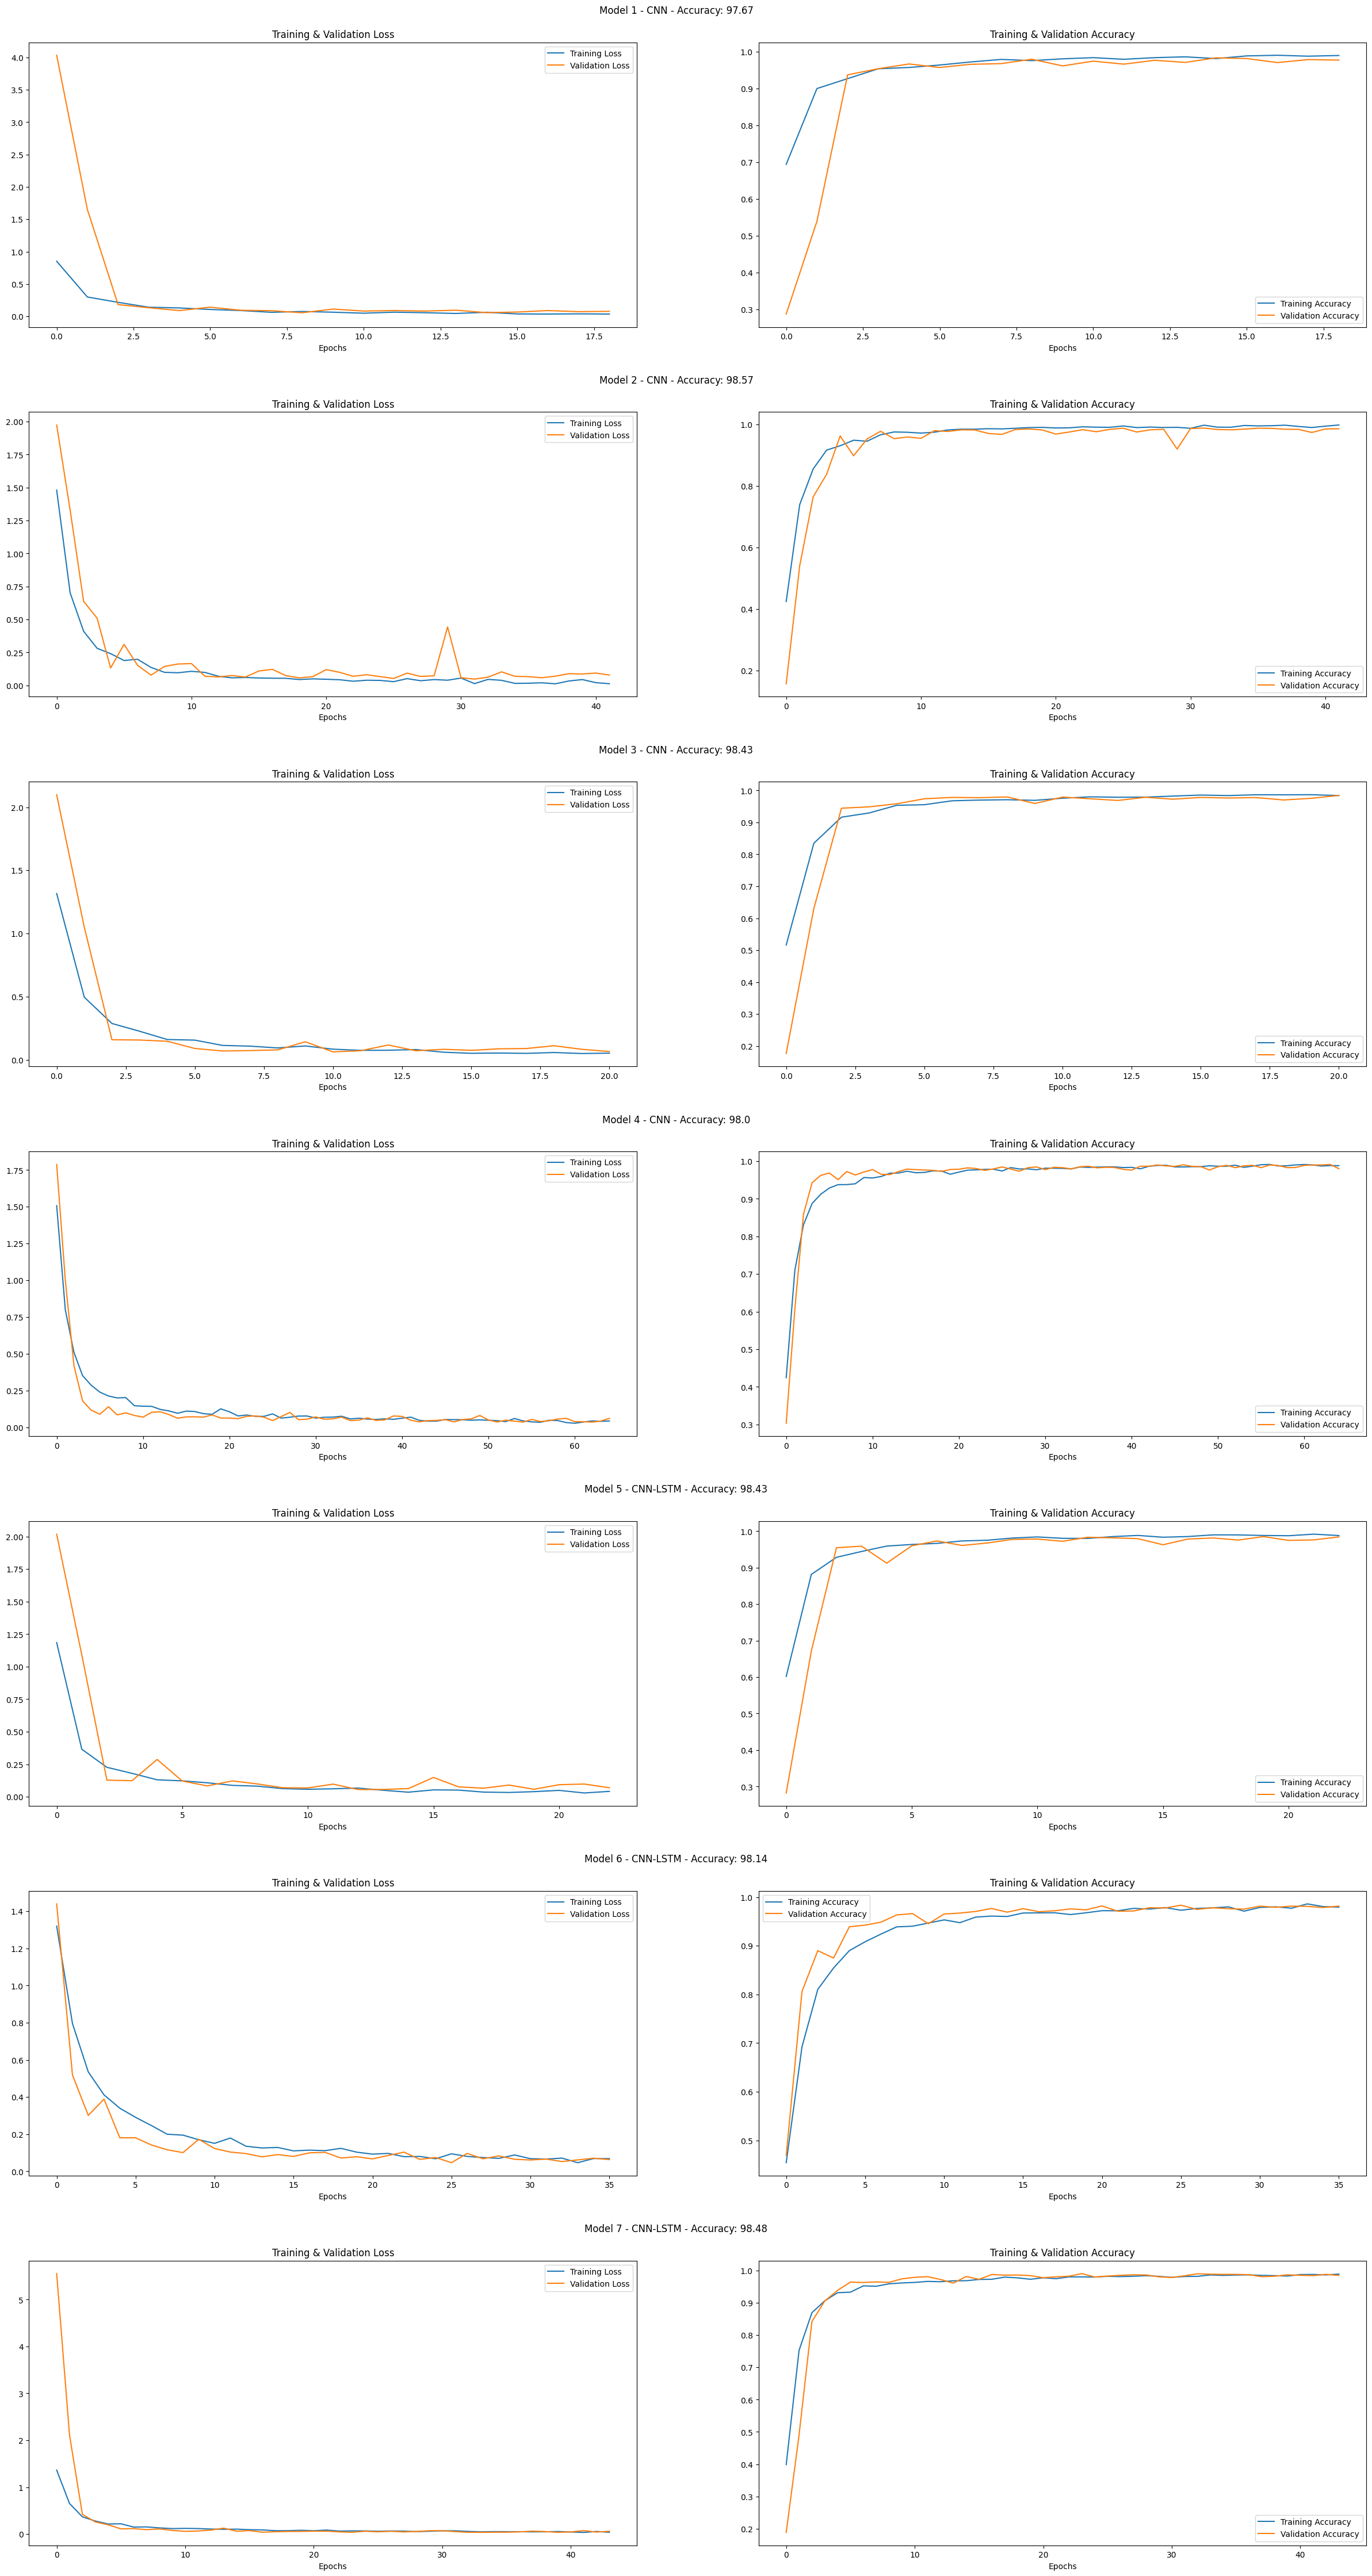

In [61]:
plot_history("Tess", tess_hist, tess_accs)

In [62]:
Ty_test = enc.inverse_transform(Ty_test)
get_classification_report(TX_test, Ty_test, tess_models, enc)

66/66 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

       angry       0.99      0.97      0.98       306
     disgust       0.98      0.95      0.97       305
        fear       0.97      1.00      0.99       305
       happy       0.95      0.99      0.97       294
     neutral       1.00      1.00      1.00       297
         sad       0.98      1.00      0.99       293
    surprise       0.97      0.93      0.95       300

    accuracy                           0.98      2100
   macro avg       0.98      0.98      0.98      2100
weighted avg       0.98      0.98      0.98      2100

              precision    recall  f1-score   support

       angry       1.00      0.98      0.99       306
     disgust       0.97      0.98      0.98       305
        fear       0.98      1.00      0.99       305
       happy       0.98      0.99      0.98       294
     neutral       1.00      1.00      1.00       297
         sad       0.99  

### 4. SAVEE

In [63]:
savee_x = np.load("savee_feats.npy")
savee_y = np.load("savee_labels.npy")
savee_x.shape, savee_y.shape

((1440, 162), (1440,))

In [64]:
savee_y = enc.fit_transform(savee_y.reshape(-1,1)).toarray()

In [65]:
SX_train, SX_test, Sy_train, Sy_test = train_test_split(savee_x, savee_y, random_state=42, shuffle=True)
scaler = StandardScaler()
SX_train = scaler.fit_transform(SX_train)
SX_test = scaler.transform(SX_test)
np.expand_dims(SX_train, axis=2)
np.expand_dims(SX_test, axis=2)
SX_train.shape, SX_test.shape, Sy_train.shape, Sy_test.shape

((1080, 162), (360, 162), (1080, 7), (360, 7))

In [66]:
savee_hist, savee_models = get_history(SX_train, Sy_train, SX_test, Sy_test)
savee_accs = get_acc(savee_models, SX_test, Sy_test)

Epoch 1/100
27/34 [======================>.......] - ETA: 0s - loss: 1.8594 - accuracy: 0.2708

2023-06-09 21:58:06.531698: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:288] gpu_async_0 cuMemAllocAsync failed to allocate 3263173632 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 29360128/4100456448
2023-06-09 21:58:06.531731: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:293] Stats: Limit:                      2218786816
InUse:                       252832764
MaxInUse:                   2234271168
NumAllocs:                   105412259
MaxAllocSize:               2192146432
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2023-06-09 21:58:06.531845: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:56] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2023-06-09 21:58:06.531860: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator

34/34 [==============================] - ETA: 0s - loss: 1.8474 - accuracy: 0.2769

2023-06-09 21:58:06.748291: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:288] gpu_async_0 cuMemAllocAsync failed to allocate 3279831040 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 29360128/4100456448
2023-06-09 21:58:06.748321: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:293] Stats: Limit:                      2218786816
InUse:                       248860832
MaxInUse:                   2234271168
NumAllocs:                   105412568
MaxAllocSize:               2192146432
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2023-06-09 21:58:06.748427: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:56] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2023-06-09 21:58:06.748431: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator

34/34 [==============================] - 3s 23ms/step - loss: 1.8474 - accuracy: 0.2769 - val_loss: 1.7404 - val_accuracy: 0.3611
Epoch 2/100
34/34 [==============================] - 0s 9ms/step - loss: 1.5854 - accuracy: 0.3639 - val_loss: 2.0726 - val_accuracy: 0.1278
Epoch 3/100
34/34 [==============================] - 0s 10ms/step - loss: 1.5149 - accuracy: 0.4213 - val_loss: 2.1412 - val_accuracy: 0.1306
Epoch 4/100
34/34 [==============================] - 0s 9ms/step - loss: 1.4304 - accuracy: 0.4407 - val_loss: 2.4199 - val_accuracy: 0.1222
Epoch 5/100
34/34 [==============================] - 0s 9ms/step - loss: 1.3399 - accuracy: 0.4685 - val_loss: 2.4079 - val_accuracy: 0.1250
Epoch 6/100
34/34 [==============================] - 0s 9ms/step - loss: 1.2753 - accuracy: 0.5093 - val_loss: 2.7452 - val_accuracy: 0.1972
Epoch 7/100
34/34 [==============================] - 0s 9ms/step - loss: 1.1946 - accuracy: 0.5213 - val_loss: 2.4216 - val_accuracy: 0.2306
Epoch 8/100
34/34 [====

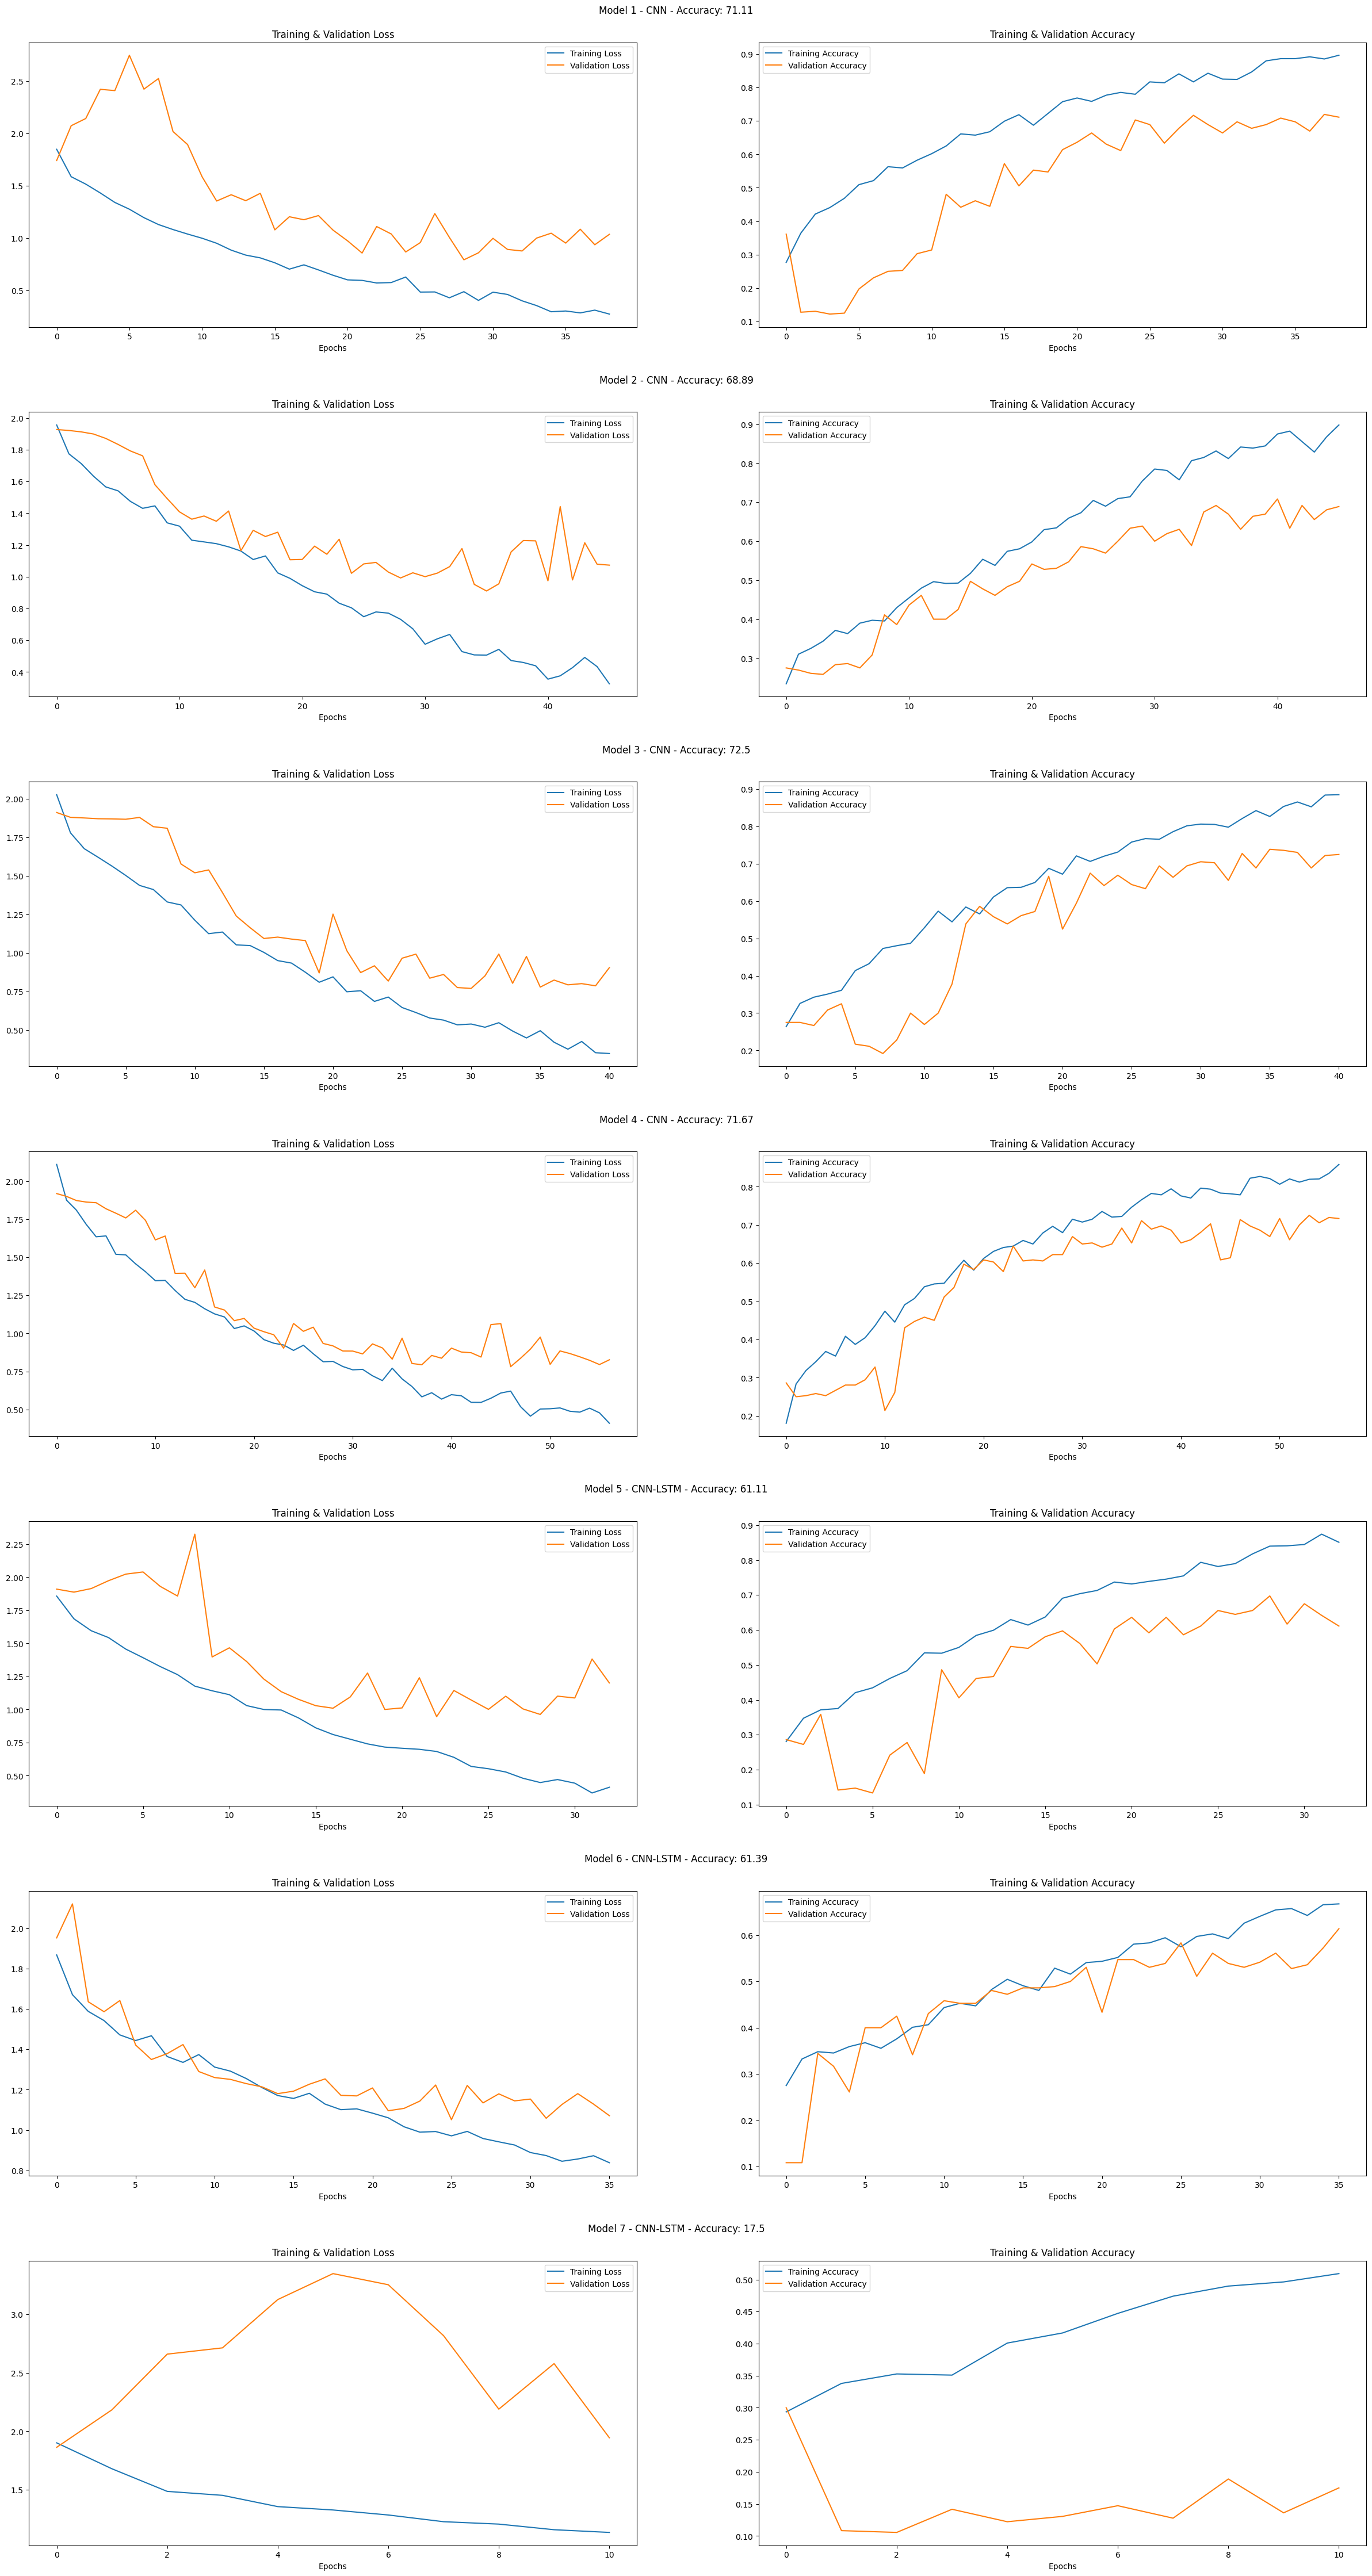

In [68]:
plot_history("Savee", savee_hist, savee_accs)

In [70]:
get_classification_report(SX_test, Sy_test, savee_models, enc)

12/12 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

       angry       0.67      0.72      0.69        47
     disgust       0.74      0.64      0.69        55
        fear       0.82      0.62      0.71        37
       happy       0.53      0.77      0.62        39
     neutral       0.74      0.89      0.81        89
         sad       0.84      0.61      0.71        44
    surprise       0.74      0.57      0.64        49

    accuracy                           0.71       360
   macro avg       0.73      0.69      0.70       360
weighted avg       0.73      0.71      0.71       360

              precision    recall  f1-score   support

       angry       0.68      0.64      0.66        47
     disgust       0.84      0.67      0.75        55
        fear       0.64      0.57      0.60        37
       happy       0.45      0.59      0.51        39
     neutral       0.84      0.80      0.82        89
         sad       0.63  